# Smart Fallback Agent

This notebook implements a **LangGraph** workflow that balances cost-efficiency and power by switching models when necessary.

**Workflow:**
* Drafting (`gpt-4o-mini`): First, the standard (lighter) agent attempts to write the Python code to solve the problem.
* Execution: The system runs the code.
* Debugging (`gpt-4o`): If (and only if) the code produces an error, the system upgrades to the more powerful GPT-4o model to diagnose the issue and rewrite the code.

This strategy ensures you use the most capable model specifically for fixing errors, while keeping standard requests fast and efficient.

In [1]:
%pip install --quiet -U langgraph
%pip install --quiet -U langchain
%pip install --quiet -U langchain-openai
%pip install --quiet -U langchain-experimental

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.4/157.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 490.2/490.2 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.8/84.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.1/210.1 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 4.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


### Connect OpenAI API & LangSmith API for tracking

In [2]:
from google.colab import drive
import os
drive.mount('/content/drive', force_remount = True)


def read_api(file_path: str) -> str:
  '''
  Read and Return OpenAI API from Drive.
  '''
  with open(file_path, 'r', encoding = 'utf-8-sig') as file:
    api_key = file.read().strip()
    return api_key


DRIVE_PATH = '/content/drive/MyDrive/api_key.txt'
api_key = read_api(file_path = DRIVE_PATH)

langsmith_api_key_file = '/content/drive/MyDrive/langsmith.txt'
langsmith_api_key = read_api(file_path = langsmith_api_key_file)


os.environ['OPENAI_API_KEY'] = api_key
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = langsmith_api_key
os.environ["LANGCHAIN_PROJECT"] = "PythonGeneration"


print("OpenAI API key loaded:", os.environ.get('OPENAI_API_KEY') is not None)
print("LangSmith API key loaded:", os.environ.get('LANGCHAIN_API_KEY') is not None)

Mounted at /content/drive
OpenAI API key loaded: True
LangSmith API key loaded: True


In [3]:
from typing import Annotated, Literal, List, TypedDict
from uuid import uuid4

# LangGraph
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langgraph.graph import START, END, StateGraph


# LangChain
from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage, ToolCall
from langchain_experimental.tools import PythonREPLTool


llm = ChatOpenAI(model = 'gpt-4o-mini', temperature = 0)
llm_advanced = ChatOpenAI(model = 'gpt-4o', temperature = 0)

In [4]:
class State(TypedDict):
  messages: Annotated[List[BaseMessage], add_messages]


def agent(state: State) -> State:
  human_msg: HumanMessage = state.get('messages')
  system_msg = SystemMessage(content = """You are a Python coding assistant.
                                    IMPORTANT: You are executing code in a standard Python shell, NOT a notebook.
                                    You cannot verify the result if you do not print it.

                                    Rules:
                                    1. Do not just write the variable name at the end.
                                    2. You MUST wrap the final result in print().

                                    Example of BAD behavior:
                                    x = 10 + 5
                                    x

                                    Example of GOOD behavior:
                                    x = 10 + 5
                                    print(x) """)
  ai_response: AIMessage | ToolCall = llm_with_tools.invoke([system_msg] + human_msg)
  return {'messages': [ai_response]}



def route(state: State) -> Literal['end', 'tool_node']:
    """
     Check if the last 'AI Message' is of type 'tool_calls',
     If so, there is a redirection to the ToolNode.
     """
    messages = state.get('messages')
    last_message = messages[-1]
    if isinstance(last_message, AIMessage) and last_message.tool_calls:
            return 'tool_node'
    return 'end'



def route_error(state: State) -> Literal['fix_agent', 'agent']:
    '''
    The "route" function checks if the last message contains one of the following words: "Traceback" or "Errors".
    If so, a more powerful model is used to try to resolve the problem.
    The route then returns "fix_agent", which redirects the flow to "error_handling".
    '''
    messages = state['messages']
    last_message = messages[-1]
    content = last_message.content
    if "Traceback" in content or "Error" in content or "not defined" in content:
        return 'fix_agent'
    return 'agent'



def error_handling(state: State) -> State:
    user_msg = state['messages']
    lst_msg = state['messages'][-1]
    system_msg = SystemMessage(content = "The previous code execution failed. Analyze the error and generate the CORRECTED code.")

    response = llm_advanced_with_tools.invoke([system_msg] + user_msg)
    return {'messages': [response]}




llm_python = PythonREPLTool()
tools = [llm_python]
tool_node = ToolNode(tools = tools)
llm_with_tools = llm.bind_tools(tools = tools)
llm_advanced_with_tools = llm_advanced.bind_tools(tools = tools)

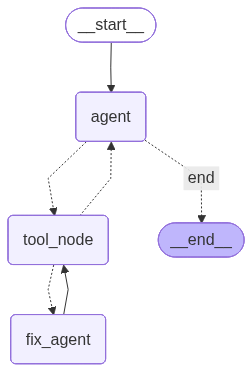

In [5]:
memory = MemorySaver()

builder = StateGraph(State)

# Nodes
builder.add_node('agent', agent)
builder.add_node('tool_node', tool_node)
builder.add_node('fix_agent', error_handling)

# Edges
builder.add_edge(start_key = START, end_key = 'agent')
builder.add_conditional_edges('agent', route, {'tool_node': 'tool_node' , 'end': END})
builder.add_conditional_edges('tool_node', route_error, {'fix_agent': 'fix_agent', 'agent': 'agent'})
builder.add_edge('fix_agent', 'tool_node')

builder.add_edge(start_key = 'agent', end_key = END)

graph = builder.compile(checkpointer = memory)
graph

### Exemples

In [6]:
cfg: dict[dict] = {'configurable': {'thread_id': str(uuid4)}}

def call_llm(query: str) -> dict:
  return graph.invoke({'messages': [HumanMessage(content = query)]}, config = cfg)

In [7]:
user = call_llm(query="I have €50,000 in a savings account earning 5% annual interest, compounded monthly. I withdraw €2,000 at the end of each month. How much will be left in the account after 2 years?")

In [8]:
lst = []

for element in user['messages']:
  if isinstance(element, HumanMessage):
    lst.append(element.content)
  if isinstance(element, AIMessage):
    if element.content == '':
      lst.append(element.tool_calls[0]['args']['query'])
    else: lst.append(element.content)

In [9]:
for element in lst:
  print(element, end = '\n\n')

I have €50,000 in a savings account earning 5% annual interest, compounded monthly. I withdraw €2,000 at the end of each month. How much will be left in the account after 2 years?

principal = 50000
annual_interest_rate = 0.05
monthly_interest_rate = annual_interest_rate / 12
withdrawal_amount = 2000
months = 2 * 12
balance = principal

for month in range(months):
    balance = balance * (1 + monthly_interest_rate) - withdrawal_amount

print(balance)

After 2 years, there will be approximately €4,875.23 left in the account.

